## Land Use Availabilities: Implementing LUISA

In [1]:
#%reset -f
import gc
import sys

import atlite
import xarray as xr
import rasterio as rio
import pandas as pd
import numpy as np
import geopandas as gpd
import shapely
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.style.use('dark_background')

from rasterio.plot import show
from atlite.gis import shape_availability, ExclusionContainer

from osgeo import gdal

import pickle

%load_ext memory_profiler

plt.rcParams['figure.figsize'] = [12, 12]

<a id='toc'></a>

## ToC </br>

### [1. Functions](#functions) </br>
### [2. Gridcodes and shape set-up](#setup)</br>
### [3. Base Case](#basecase)</br>
#### [3.1 CORINE](#basecase_corine)</br>
#### [3.2 LUISA](#basecase_luisa)</br>
### [4. Comparing 'inclusion' grdicodes: CORINE vs. LUISA](#loop1)</br>
### [5. Comparing 'exclusion' gridcodes: CORINE vs. LUISA](#loop2)</br>
### [6. Agora Windlfächenrechner data](#agora)</br>
### [7. Further exclusion zones](#ecol)</br>
### [8. Memory Profile and Mask Sizes](#memprof)

<a id='functions'></a>

### 1. Functions

In [2]:
# Utilised functions in Notebook
def write_geotiff(filename, mask, trans, proj = 'epsg:3035'):
    """
    Write np.array to GeoTiff rasterfile. Utilizes mask and transfrom objectes returned from atlite.shape_availibility()
    
    Parameters
    ----------
    
    filename : 'str'
    mask : numpy.ndarray
        Array containing raster matrix returned from shape_availability()[0]
    trans : Affine()
        Geometry information returned from shape_availability()[1]
    proj : str()
        Projection valid by gdal.driver.SetProjection()
        Default: 'epsg:3035'      
    """
    
    if mask.dtype == np.float32:
        arr_type = gdal.GDT_Float32
    else:
        arr_type = gdal.GDT_Int32

    driver = gdal.GetDriverByName("GTiff")
    
    out_ds = driver.Create(filename, mask.shape[1], mask.shape[0], 1, arr_type)
    out_ds.SetProjection(proj)
    out_ds.SetGeoTransform([trans[2], trans[0], trans[1], trans[5], trans[3], trans[4]])
    
    band = out_ds.GetRasterBand(1)
    band.WriteArray(mask)
    band.FlushCache()


# Filter country shapes for area that is covered by Luisa.

def tif_bb_filter(raster, shapes, output_crs = 'raster'):
    '''
    Reduce gpd shape or shape collection to bounding box of a .tif raster via gpd.overlay
    
    Parameters
    ----------
    raster : rasterio.DatasetReader
        Raster file
    shapes : gpd.DataFrame
        Geopandas DataFrame containing geometry collection
    output_crs : 'str'
        Either 'raster' or 'shapes' which specifies the desired output crs
    
    Returns
    _______
    gpd.DataFrame object restricted by tif raster bounds 
    
    '''
    bb = shapely.geometry.box(*raster.bounds)
    bb = gpd.GeoDataFrame(gpd.GeoSeries(bb), columns=['geometry'], crs=raster.crs)
    
    shapes_crs_adj = shapes.to_crs(raster.crs)

    shapes_filtered = gpd.overlay(shapes_crs_adj, bb, how='intersection')
    
    if output_crs == 'shapes':
        shapes_filtered = shapes_filtered.to_crs(shapes.crs)

    return shapes_filtered


def mte(exc, country, share_kind = "normal"):
    """
    Function that wraps the calculation of mask and transform affine output from atlite.shape_availibility()
    as well as the calculation of the eligible_share
    
    Parameters
    __________
    
    exc = atlite.ExculsionContainer
    country = gpd.DataFrame
    share_kind = str
    
    Returns
    _______
    
    list where,
    [0] = masked (array)
    [1] = transform (Affine())
    [2] = eligible_area (num)
    [3] = eligible_share (num)  
    """
    
    masked, transform = shape_availability(country, exc)
    eligible_area = masked.astype(float).sum() * exc.res**2

    if share_kind == "normal":
        eligible_share =  eligible_area / country.geometry.item().area
    elif share_kind == "inverse":
        eligible_share =  1-(eligible_area / country.geometry.item().area)

    mte_results = [masked, transform, eligible_area, eligible_share]

    return mte_results


def invert(array):
    """
    Inverts an array. Turns 0 to 1 and 1 to 0 simultaneously.
    Used for inverting maksed objects from atlite.shape_availibility()
    Contents must be type == int for bitwise XOR
    
    Parameters
    __________
    
    array : np.array
    """
    
    a = array.astype(int)
    b = np.where((a==0)|(a==1), a^1, a)
    
    return b

def open_dict(file):
    """
    Opens pickle dump
    """
    
    with open(file, 'rb') as f:
        dta_import = pickle.load(f)
    return dta_import


def side_by_side(m1, t1, e1, m2, t2, e2, c_shape, title, savepath = None, close = False, dpi=100):
    '''
    Creating side-by-side plot for two masked rasters
    
    Parameters
    __________
    
    m1, m2 : numpy.ndarray
        Array containing raster matrix returned from shape_availability()[0]
    t1, t2 : Affine()
        Geometry information for transfomation in plotting raster
    e1, e2 : numpy.float64
        Eligible share [0,1]
    c_shape : gpd.DataFrame
        Geopandas DataFrame containing geometry collection.
    title : 'str'
    savepath : 'str' or None
        Default: None
        If None, plot is not saved 
    close : bool
        Default: None
        If True, plt.close(fig) is run
        Useful for saving memory when plots are produced in loop
    '''

    fig, ax = plt.subplots(1,2, figsize=(18,12), dpi = dpi,
                          num=1, clear=True) # Helps with memory preservation

    ax[0] = show(m1, transform=t1, cmap='Greens', ax=ax[0])
    c_shape.plot(ax=ax[0], edgecolor='k', color='None')
    ax[0].set_title(f'LUISA Data: Eligible area (green) {e1 * 100:2.2f}%', size=16);

    ax[1] = show(m2, transform=t2, cmap='Greens', ax=ax[1])
    c_shape.plot(ax=ax[1], edgecolor='k', color='None')
    ax[1].set_title(f'CORINE Data: Eligible area (green) {e2 * 100:2.2f}%', size=16);
    
    fig.tight_layout()

    if title != None:
        plt.suptitle(title, y=1.01, size=16)
        
    if savepath != None:
        plt.savefig(savepath, bbox_inches='tight')
        
    if close == True:
        plt.close(fig)

<a id='setup'></a>

### 2. Gridcodes and shape set-up
##### [Back to ToC](#toc)

In [3]:
# Excel with necessary information on the shapes luisa / corine cover, as well as the gridcodes
gc_excel = pd.read_excel('./landuse_availability/gridcode_dict.xlsx', sheet_name = 'py_dict_format', 
                         converters = {'in_gc_luisa' : int, 'in_gc_corine' : int, 'ex_gc_luisa' : int, 'ex_gc_corine': int})

<AxesSubplot:>

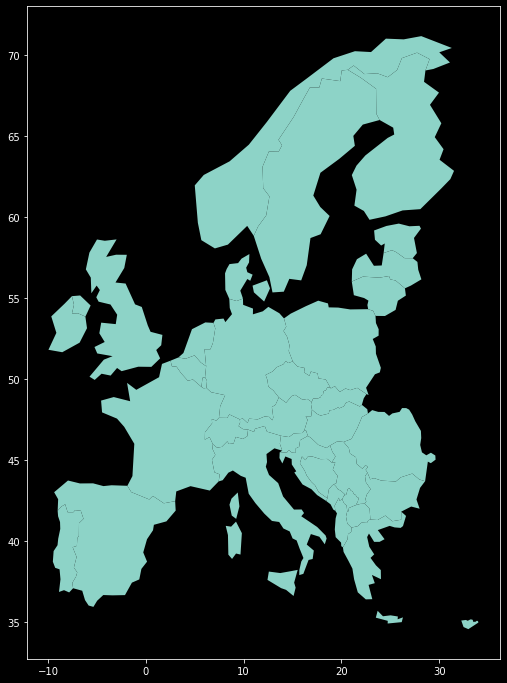

In [4]:
# set up country shapes 
raster = rio.open('C:/CaT/Masterthesis/data/corine.tif')
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

shapes = tif_bb_filter(raster = raster, shapes = world, output_crs = 'shapes')

# There are no shapes for Liechtenstein & Malta in the gpd library. Turkey and Iceland are excluded as they are not in focus of the analysis 
shapes = shapes[shapes['name'].isin(list(gc_excel['countries']))]
shapes.set_index('name', inplace=True)
shapes.drop(['Iceland', 'Turkey'], inplace = True)

shapes.plot()

In [5]:
# set up gridcode dictionary. see ./gridcodes.xlsx for further reference
gridcodes = {
    'inclusion' : 
    {
        'luisa' : dict(zip(gc_excel['in_gc_type'], gc_excel['in_gc_luisa'])),
        'corine' : dict(zip(gc_excel['in_gc_type'], gc_excel['in_gc_corine']))
    },
    'exclusion' :
    {
        'luisa' : dict(zip(gc_excel['ex_gc_type_luisa'].dropna(), gc_excel['ex_gc_luisa'].dropna())),
        'corine' : dict(zip(gc_excel['ex_gc_type_corine'].dropna(), gc_excel['ex_gc_corine'].dropna()))
    }
}


LUISA = 'C:/CaT/Masterthesis/data/luisa.tif'
CORINE = 'C:/CaT/Masterthesis/data/corine.tif'

<a id='basecase'></a>

### 3. Base Cases
##### [Back to ToC](#toc)

<a id='basecase_corine'></a>

#### 3.1 CORINE

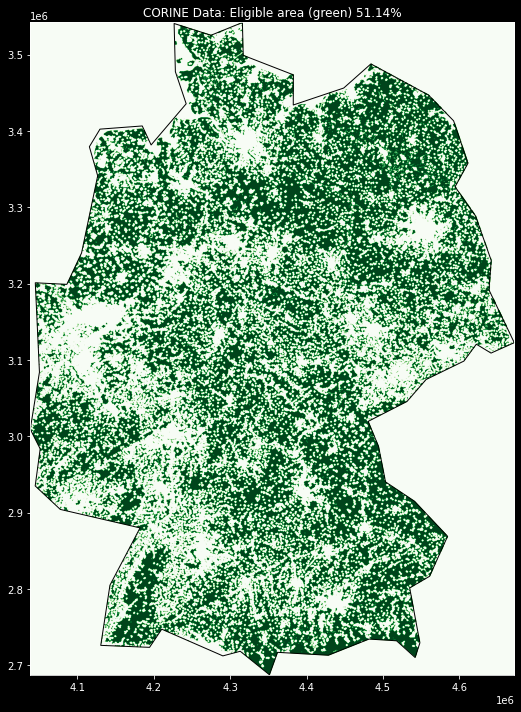

In [8]:
cntry = 'Germany'

# set up raster
exc_corine = ExclusionContainer(res=100)
exc_corine.add_raster(CORINE, codes = list(gridcodes['inclusion']['corine'].values()), crs=3035, invert=True)
exc_corine.add_raster(CORINE, codes = list(gridcodes['exclusion']['corine'].values()), crs=3035,  buffer=1000)

# pick a country
country = shapes.loc[[cntry]].geometry.to_crs(exc_corine.crs)

# get availibility mask and transformation affine 
masked_c, transform_c = shape_availability(country, exc_corine)
eligible_share_c = masked_c.sum().astype(float) * exc_corine.res**2 / country.geometry.item().area

#Save mask as geotiff
#write_geotiff(f'./{cntry}.tif', mask = masked_c, trans = transform_c) 

# plot
fig, ax = plt.subplots()
ax = show(masked_c, transform=transform_c, cmap='Greens', ax=ax)
country.plot(ax=ax, edgecolor='k', color='None')
ax.set_title(f'CORINE Data: Eligible area (green) {eligible_share_c * 100:2.2f}%');

# Berlin coordinates
#ax.set_ylim(3290000,3250000)
#ax.set_xlim(4520000, 4580000)

#plt.savefig('./landuse_availability/test.png')
#plt.close(fig)

<a id='basecase_luisa'></a>

#### 3.2 LUISA 

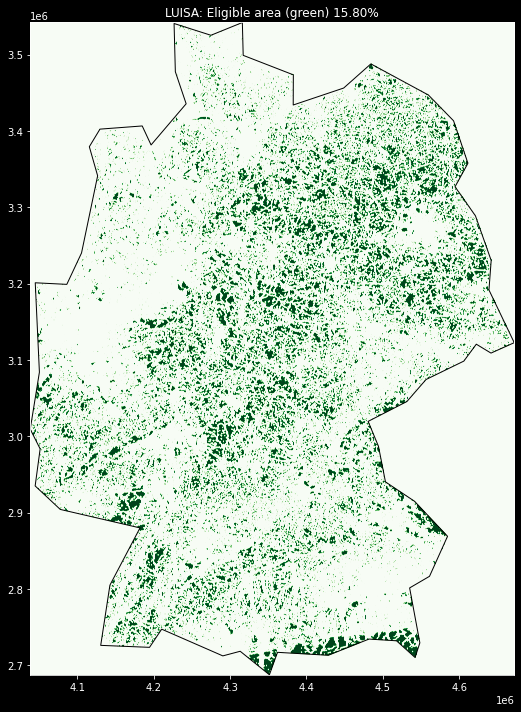

In [6]:
# pick country
cntry = 'Germany'

# set up raster
exc_luisa = ExclusionContainer(res=50)
exc_luisa.add_raster(LUISA, codes = list(gridcodes['inclusion']['luisa'].values()), crs=3035, invert=True)
exc_luisa.add_raster(LUISA, codes = list(gridcodes['exclusion']['luisa'].values()), crs=3035,  buffer=1000)

# pick a country
country = shapes.loc[[cntry]].geometry.to_crs(exc_luisa.crs)

# get availibility mask and transformation affine 
masked_l, transform_l = shape_availability(country, exc_luisa)
eligible_share_l = masked_l.astype(float).sum() * exc_luisa.res**2 / country.geometry.item().area

#Save mask as geotiff
#write_geotiff(f'./{cntry}.tif', mask = masked_c, trans = transform_c) 

#plot 
fig, ax = plt.subplots()
ax = show(masked_l, transform=transform_l, cmap='Greens', ax=ax)
country.plot(ax=ax, edgecolor='k', color='None')
ax.set_title(f'LUISA: Eligible area (green) {eligible_share_l * 100:2.2f}%');

# Berlin coordinates
#ax.set_ylim(3290000,3250000)
#ax.set_xlim(4520000, 4580000)

#plt.savefig('./landuse_availability/luisa_available_berlin.png')
#plt.savefig('./landuse_availability/test.png')
#plt.close(fig)

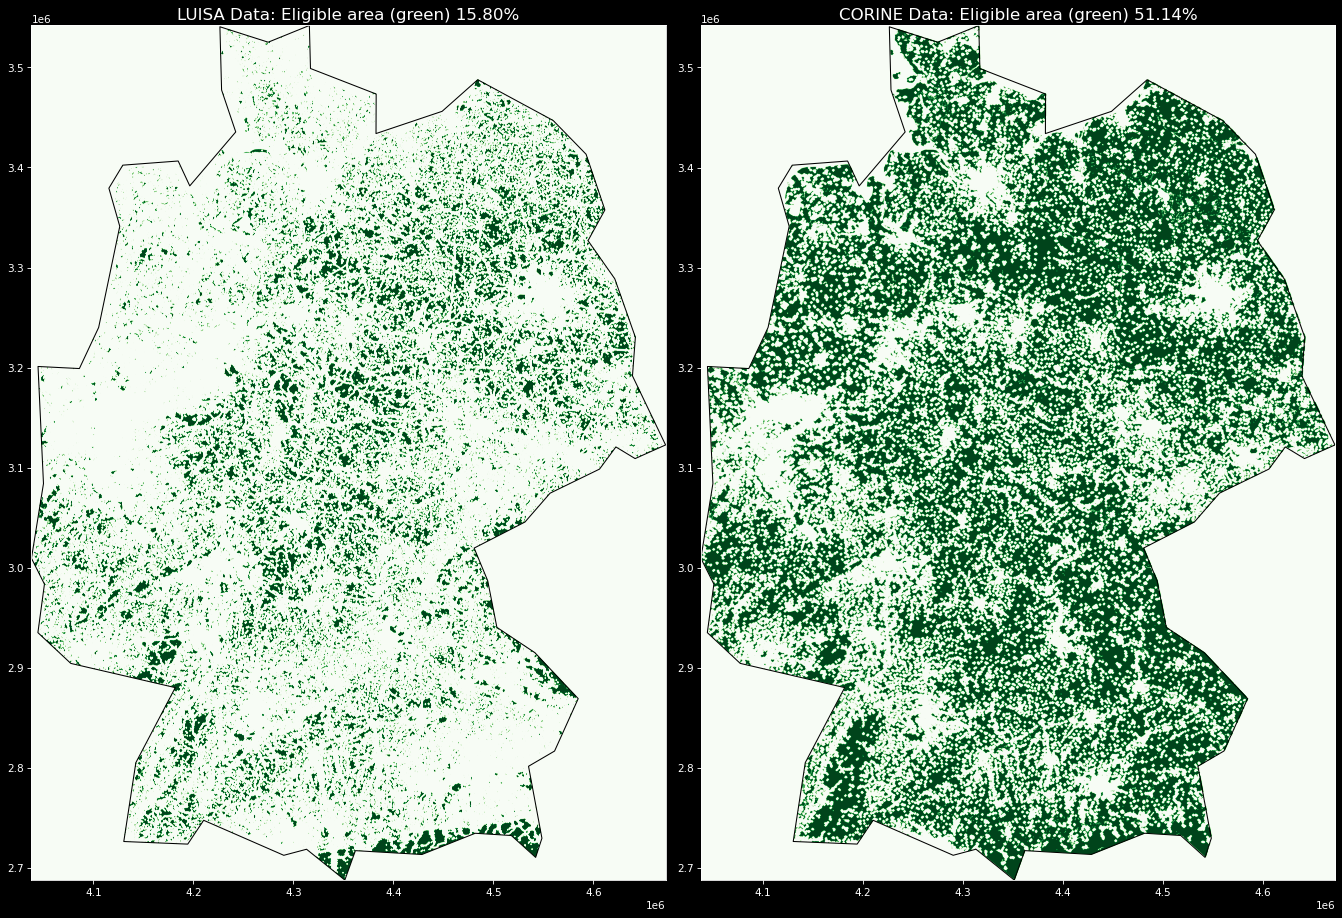

In [9]:
# Optional side by side plot
side_by_side(m1=masked_l, t1=transform_l, e1=eligible_share_l,
             m2=masked_c, t2=transform_c, e2=eligible_share_c,
             c_shape=country, title=None, savepath = None, close = False,
             dpi = 75)

<a id='loop1'></a>

### 4. Loop 1: Comparing 'inclusion' grid codes and eligible share: CORINE vs. LUISA
##### [Back to ToC](#toc)

In [ ]:
%%time
# Check how land use changes for codes among CORINE and LUISA for given inclusion gridcodes
# len(inclusion gridcodes luisa) == len(inclusion gridcodes corine)! 

generate_plot = False

ls = []

for cntry in shapes.index:
    
    shape = shapes.loc[[cntry]].geometry.to_crs(3035)
    
    for gc_idx in range(0,len(gridcodes['inclusion']['luisa'])):

        # setup exclusion containers 
        exc_luisa, exc_corine = ExclusionContainer(res=50), ExclusionContainer(res=100) 
        
        exc_luisa.add_raster(LUISA, codes = list(gridcodes['inclusion']['luisa'].values())[gc_idx], crs=3035, invert=True)
        exc_corine.add_raster(CORINE, codes = list(gridcodes['inclusion']['luisa'].values())[gc_idx], crs=3035, invert=True)
        
        landuse = []
        plot = []
        
        for exc in [exc_luisa, exc_corine]:
            
            mte_results = mte(exc, shape, share_kind="normal")
    
            landuse.extend([mte_results[2], mte_results[3]])
        
            if generate_plot == True:
                plot.extend([mte_results[0], mte_results[1]])

        ls.append([cntry,
                   list(gridcodes['inclusion']['luisa'].keys())[gc_idx],
                   list(gridcodes['inclusion']['luisa'].values())[gc_idx],
                   list(gridcodes['inclusion']['corine'].values())[gc_idx],
                   *landuse])
        
        # Create plots
        if generate_plot == True:
            side_by_side(plot[0], plot[1], landuse[1], plot[2], plot[3], landuse[3],
                       title = None, c_shape = shape, 
                       savepath = './landuse_img/inclusion_img/{}_{}.png'.format(cntry, list(gridcodes['inclusion']['luisa'].keys())[gc_idx].replace(' ', '_')),
                       close = True)
  
        print(cntry,  list(gridcodes['inclusion']['luisa'].keys())[gc_idx])
    
        #Useful for memory preservation, espcially when looping through large countries that create large matrices, eg. Finland, Norway
        del mte_results, plot
        gc.collect()

In [20]:
inclusion_results = pd.DataFrame(ls, columns=['country', 'landuse',
                                    'gridcode_luisa', 'gridcode_corine',
                                    'landuse_area_luisa', 'landuse_share_luisa',
                                    'landuse_area_corine', 'landuse_share_corine'])

inclusion_results['area_diff'] = inclusion_results['landuse_area_luisa'] - inclusion_results['landuse_area_corine'] 
inclusion_results['share_diff'] = inclusion_results['landuse_share_luisa'] - inclusion_results['landuse_share_corine'] 

#### results are saved within ./results/gridcode_db.xlsx ['inclusion']

<a id='loop2'></a>

### 5. Loop 2:  Comparing 'exclusion' grid codes and occupation share: CORINE vs. LUISA
##### [Back to ToC](#toc)

In [ ]:
%%time

crs = 3035

buffer_dis = [0,200,400,600,800,1000]

ls = []
for cntry in shapes.index[8:9]:

    country = shapes.loc[[cntry]].geometry.to_crs(3035)

    for dis in buffer_dis:
        
        #### LUSIA ####
        
        # Preliminary calculation of all dis_gc applied + the empty bounding inverted
        # only needed oncec for one country
        # full
        exc_luisa = ExclusionContainer(res=50)
        exc_luisa.add_raster(LUISA, codes = list(gridcodes['exclusion']['luisa'].values()), crs=3035, buffer = dis)
        full = mte(exc_luisa, country, share_kind = "inverse")

        ls.append(['LUISA', cntry, 'all', 'all', dis, full[3], 1])

        # empty
        exc_luisa = ExclusionContainer(res=50)
        exc_luisa.add_raster(LUISA, codes = [9999], crs=3035)  # 9999 returns fully eligible space
        empty = mte(exc_luisa, country)

        full_boundless = invert(full[0]) - invert(empty[0])

        del empty
        gc.collect()

        for gc_idx in range(0,len(gridcodes['exclusion']['luisa'])):

            # restricted
            exc_luisa = ExclusionContainer(res=50)
            exc_luisa.add_raster(LUISA, codes = list(gridcodes['exclusion']['luisa'].values())[gc_idx], crs=3035, buffer = dis)

            restricted = mte(exc_luisa, country, share_kind = "inverse")

            filtered = full_boundless - restricted[0]
            filtered[filtered == -1] = 0

            share_full = 1 - ((full[0].astype(float).sum() * exc_luisa.res**2) /  country.geometry.item().area)
            share_filtered = filtered.astype(float).sum() * exc_luisa.res**2 / country.geometry.item().area

            share_restricted = share_filtered / share_full

            ls.append(['LUISA', cntry, 
                       list(gridcodes['inclusion']['luisa'].keys())[gc_idx],
                       list(gridcodes['inclusion']['luisa'].values())[gc_idx],
                       dis, restricted[3], share_restricted])

            print('luisa', cntry, list(gridcodes['inclusion']['luisa'].keys())[gc_idx], dis)

            del filtered, restricted
            gc.collect()

        del full, full_boundless
        gc.collect()

        #### CORINE ###
        # Preliminary calculation of all dis_gc applied + the empty bounding inverted
        # only needed oncec for one country
        #full
        exc_corine = ExclusionContainer(res=100)
        exc_corine.add_raster(CORINE, codes = list(gridcodes['exclusion']['luisa'].values()), crs=3035, buffer = dis)
        full = mte(exc_corine, country, share_kind = "inverse")

        ls.append(['CORINE', cntry, 'all', 'all', dis, full[3], 1])

        # empty
        exc_corine = ExclusionContainer(res=100)
        exc_corine.add_raster(CORINE, codes = [9999], crs=3035)
        empty = mte(exc_corine, country)

        full_boundless = invert(full[0]) - invert(empty[0])

        del empty
        gc.collect()

        for gc_idx in range(0,len(gridcodes['exclusion']['corine'])):

            # restricted
            exc_corine = ExclusionContainer(res=100)
            exc_corine.add_raster(CORINE, codes = list(gridcodes['exclusion']['luisa'].values())[gc_idx], crs=3035, buffer = dis)

            restricted = mte(exc_corine, country, share_kind = "inverse")

            filtered = full_boundless - restricted[0]
            filtered[filtered == -1] = 0

            share_full = 1 - ((full[0].astype(float).sum() * exc_corine.res**2) /  country.geometry.item().area)
            share_filtered = filtered.astype(float).sum() * exc_corine.res**2 / country.geometry.item().area

            share_restricted = share_filtered / share_full

            ls.append(['CORINE', cntry, 
                       list(gridcodes['exclusion']['luisa'].keys())[gc_idx],
                       list(gridcodes['exclusion']['luisa'].values())[gc_idx],
                       dis, restricted[3], share_restricted])

            print('corine', cntry, list(gridcodes['inclusion']['luisa'].keys())[gc_idx], dis)

            del filtered, restricted
            gc.collect()
            

In [25]:
exclusion_results = pd.DataFrame(ls, columns = ['raster', 'country', 'type', 'dis_gridcode', 'buffer_distance', 'landuse_share', 'exclusion_share'])
#### results are saved within ./results/gridcode_db.xlsx ['inclusion']

<a id='agora'></a>


### 6. Agora Windflächenrechner Data

##### [Back to ToC](#toc)


Utilises Agroa Windflächenrechner dataset on eligible areas for <br/>

- 1000m distance to settlements
- no forrest use
- no land protective area use

Dataset is read in from pickle dump containing GeoJSON. 
Retrieved in seperate notebook './agora_wfr_scraper.ipynb'


In [6]:
data1000 = open_dict('C:/CaT/Masterthesis/data/data1000_z11.pckl')

# Initialize empty GeoDataFrame
potential_area_1000 = gpd.GeoDataFrame()

tile_count = len(data1000['potential_area'])

# Fill the GeoDataFrame with the GeoJSON dict entries
# One entry represents one polygon
potential_area_1000 = potential_area_1000.append([gpd.GeoDataFrame.from_features(data1000['potential_area'][i]['features']) for i in range(0,tile_count)])

In [7]:
# Adjust CRS
potential_area_1000 = potential_area_1000.set_crs(4326)
potential_area_1000_crs3035 = potential_area_1000.to_crs(3035)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world_3035 = world.to_crs('epsg:3035')
germany = world_3035[world_3035['name'] == 'Germany']

potential_area_1000_crs3035_match = gpd.overlay(potential_area_1000_crs3035, germany, how = 'intersection')

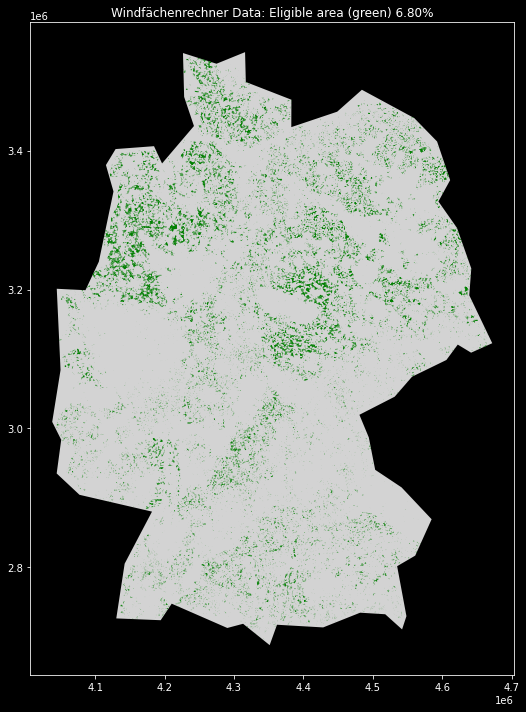

In [8]:
fig, ax = plt.subplots()

germany.plot(color="lightgrey", ax=ax)
potential_area_1000_crs3035_match.plot(color="green", ax=ax, aspect='equal')

share = potential_area_1000_crs3035_match.area.sum()/germany.geometry.item().area

ax.set_title(f'Windfächenrechner Data: Eligible area (green) {share * 100:2.2f}%');

ax.set_aspect('equal')

In [9]:
# Comparison to Luisa with 1000m distance, forest areas excluded 

forest = {'Broad-leaved forest', 'Coniferous forest', 'Mixed forest'}
gc_inclusion_luisa_noforest = {x: gridcodes['inclusion']['luisa'][x] for x in gridcodes['inclusion']['luisa'] if x not in forest}

exc_luisa = ExclusionContainer(res=50)
exc_luisa.add_raster(LUISA, codes = list(gc_inclusion_luisa_noforest.values()), crs=3035, invert=True)
exc_luisa.add_raster(LUISA, codes = list(gridcodes['exclusion']['luisa'].values()), crs=3035,  buffer=1000)

luisa_noforest = mte(exc_luisa, germany.geometry, share_kind='normal')

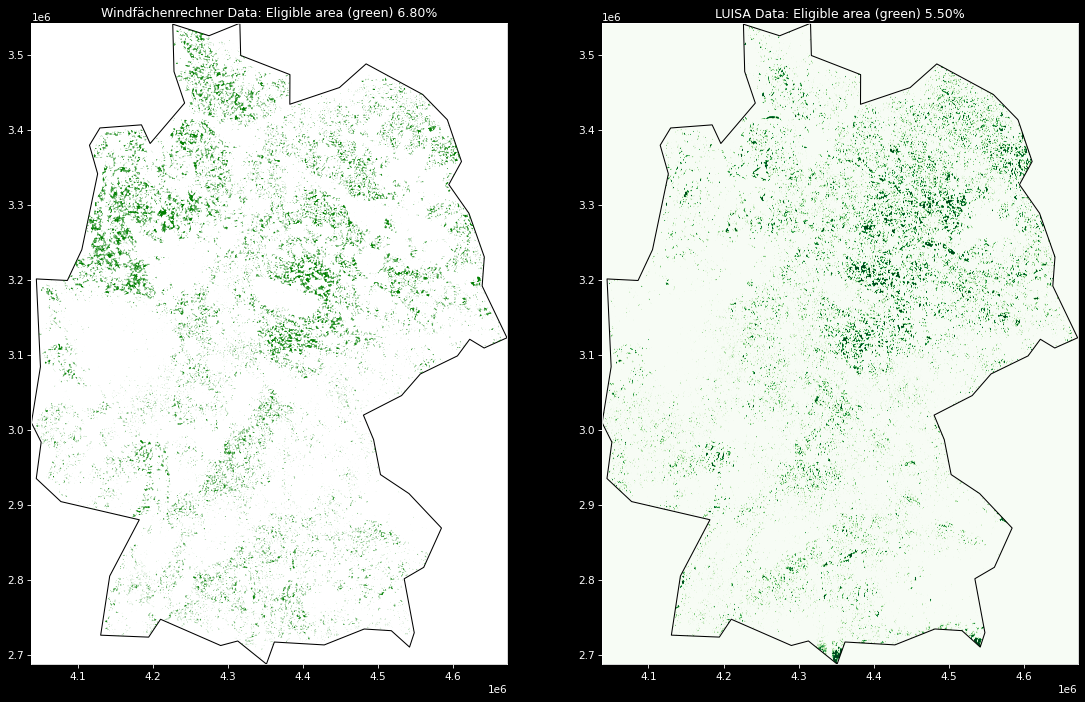

In [10]:
fig, ax = plt.subplots(1,2, figsize=(18,12), dpi = 75)

germany.plot(color="none", edgecolor='k', ax=ax[0])
potential_area_1000_crs3035_match.plot(color="green", ax=ax[0], aspect='equal')
ax[0].set_title(f'Windfächenrechner Data: Eligible area (green) {share * 100:2.2f}%');
ax[0].set_xlim(germany.bounds['minx'].values, germany.bounds['maxx'].values)
ax[0].set_ylim(germany.bounds['miny'].values, germany.bounds['maxy'].values)
ax[0].set_facecolor('white')

ax[1] = show(luisa_noforest[0], transform=luisa_noforest[1], cmap='Greens', ax=ax[1])
germany.plot(ax=ax[1], edgecolor='k', color='None')
ax[1].set_title(f'LUISA Data: Eligible area (green) {luisa_noforest[3] * 100:2.2f}%');

plt.show()

<a id='ecol'></a>


### 7. Further exclusion zones: Ecologically sensitive areas

##### [Back to ToC](#toc)
 

Utilised for this example is the dataset on Nationally designated areas (CDDA), by the European Environmental Agency (EEA) </br>
Can be found at: https://www.eea.europa.eu/data-and-maps/data/nationally-designated-areas-national-cdda-16</br>
CDDA EuropeEPSG3035 (GeoPackage file), ca 650 MB

In [11]:
cdda = gpd.read_file('./data/CDDA_2021_v01_public_EuropeEPSG3035_gpkg/CDDA_2021_v01_public_EuropeEPSG3035.gpkg')

In [21]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world_3035 = world.to_crs('epsg:3035')
germany = world_3035[world_3035['name'] == 'Germany']

In [13]:
# Filter for Germany and reduce to gpd.shape
cdda_de = cdda[cdda['cddaCountryCode'] == 'DE']
cdda_de_match = gpd.overlay(cdda_de, germany, how='intersection')

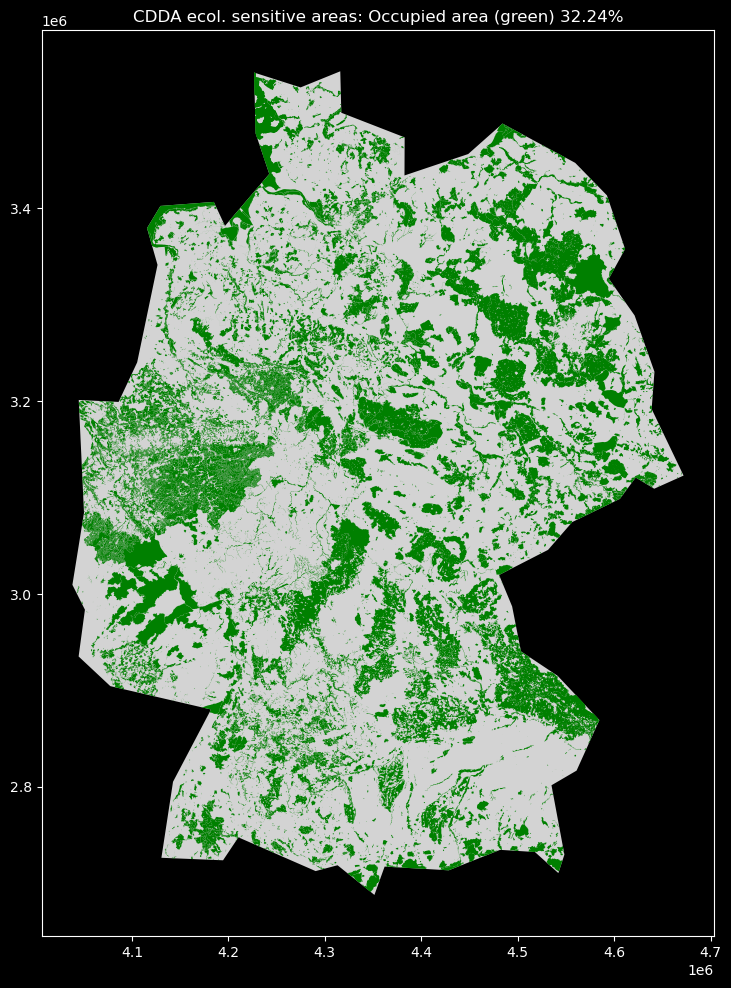

In [15]:
fig, ax = plt.subplots(dpi = 100)

germany.plot(ax=ax, color = 'lightgrey')
cdda_de_match.plot(ax=ax, color = 'green')

share = cdda_de_match.area.sum()/germany.geometry.item().area

ax.set_title(f'CDDA ecol. sensitive areas: Occupied area (green) {share * 100:2.2f}%')

plt.show()

<a id='memprof'></a>
### 8. Memory Profile and Mask sizes

##### [Back to ToC](#toc)

In [7]:
exc_luisa = ExclusionContainer(res=50)
exc_luisa.add_raster(LUISA, codes = list(gridcodes['inclusion']['luisa'].values()), crs=3035, invert=True)
exc_luisa.add_raster(LUISA, codes = list(gridcodes['exclusion']['luisa'].values()), crs=3035,  buffer=1000)

country = shapes.loc[['Germany']].geometry.to_crs(exc_luisa.crs)

# Create memory profile
%mprun -f shape_availability shape_availability(country, exc_luisa)

In [10]:
masked, transform = shape_availability(country, exc_luisa)

In [19]:
for i in [masked.dtype, 'int', 'float']:
    print(i, ': ', sys.getsizeof(masked.astype(i))/1000000, ' MiB')

bool :  216.633522  MiB
int :  866.533704  MiB
float :  1733.06728  MiB
